# Boston Data: Feature Selection
## Intro
Feature selection is the process of extracting the subset of features which will enable you to build a model that is:
* Accurate - redundant/irrelevant variables confuse your model and actually decrease its accuracy by muddying the strength of positive relationships between your relevant variables and target
* Fast - by reducing number of variables (and so data) that need to be processed
* Not overfitted - redundant variables will confuse the model and force it to train itself on non-relationships

There are 3 main types of selection methods which we will look at here and we will describe the details in each section below:
* Filtering method
* Wrapper method
* Embedded method

**Project Link:** https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b

## Loading the Data
Before diving into any of the methods, we need to load our data. Here, we will be using one of the pre-existing SKLearn datasets for Boston which contains 14 feature variables and our target variable **MEDV**. It is important to note that because all of our data here is **continuous numerical** data, this is a regression problem and we will be using statistical methods and models that fit this problem.

In [1]:
# load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston

# show plots in notebook
%matplotlib inline

# load data
data = load_boston()

# convert to df
df = pd.DataFrame(data=data.data, columns=data.feature_names) # convert features from array to df
df['MEDV'] = data.target # add y/target variable

# extract features and target
X = df.drop('MEDV', 1)
y = df['MEDV']

# show data
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## Filtering Method
This is the **simplest, quickest yet least accurate** method of feature selection. It scores each feature variable and simply eliminates those which fall under your specified threshold score. Most commonly this is a **univariate method** which looks at variables either in isolation or in combination with the target variable. It often uses a **correlation matrix** and commonly implements the **Pearson correlation coefficient** to determine a score. Here, we will use 0.5 as the threshold for eliminating feature variables.

A key feature of the filtering method is that you **run your feature selection before you build your model**, whereas in the wrapper and embedded methdos you iteratively enhance your model based on its score with different feature combinations.

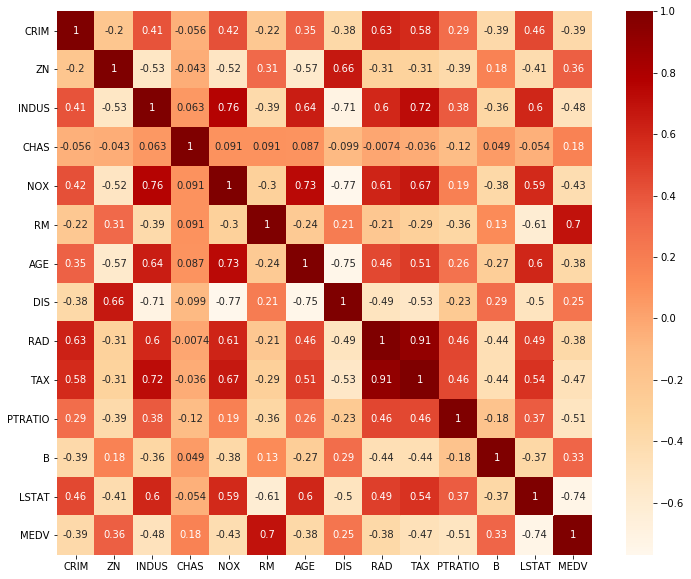

In [2]:
# calculate correlation of all variables (incl. target)
corr = df.corr()

# plot in correlation plot
plt.figure(figsize=(12, 10)) # define figure size
sns.heatmap(corr, cmap='OrRd', annot=True) # plot correlation
plt.show() # show plot

We can see from the above correlation heatmap that 3 variables have more than a 0.5 (or -0.5) correlation with our MEDV target variable. We will extract these initially.

It's also important to note that for a regression problem you cannot use multiple features which are correlated with one another as it will throw off your model **(multi-collinearity problem)**. Therefore, we need to do a check to see if any of the 3 features we've selected are correlated.

In [3]:
# get absolute correlation (convert -ve to +ve)
corr_target = abs(corr['MEDV'])

# extract features with > 0.5 abs. correlation only
ext_feat = corr_target[corr_target>0.5]
ext_feat # show results

RM         0.695360
PTRATIO    0.507787
LSTAT      0.737663
MEDV       1.000000
Name: MEDV, dtype: float64

In [4]:
# check correlation of extracted variables
print(df[['RM', 'LSTAT']].corr())
print(df[['RM', 'PTRATIO']].corr())
print(df[['PTRATIO', 'LSTAT']].corr())

             RM     LSTAT
RM     1.000000 -0.613808
LSTAT -0.613808  1.000000
               RM   PTRATIO
RM       1.000000 -0.355501
PTRATIO -0.355501  1.000000
          PTRATIO     LSTAT
PTRATIO  1.000000  0.374044
LSTAT    0.374044  1.000000


We can see here that RM and LSTAT are quite highly correlated (-61%), therefore we need to drop one of these. LSTAT has a better correlation with our target variable (74%) than RM (69%) therefore we will drop RM from our extracted features list.

Therefore, we end up with 2 features from our original full dataset - **LSTAT and PTRATIO**.

## Wrapper Method
As mentioned earlier, the filter method is good for quick selection on large datasets (because it's inexpensive to run) and can also be used to identify multi-collinearity. However, it isn't as accurate as the wrapper or embedded methods so, whilst the latter two methods can be more expensive, they are better if possible.

Note that because the wrapper method is iterative it takes up more memory, time and processing power, therefore it is advisable to use it on datasets with **~20 features or less** for optimal performance.

The wrapper method differs to the filter method because instead of extracting features and then building the model, it **iteratively enhances the model by assessing its accuracy based on selected features**.

There are many wrapper methods we could use, but here we will look at just two; **Backward Elimination** and **Recursive Feature Elimination**.

### i) Backward Elimination
Here, we iteratively build our model, assess its accuracy and then remove the features we deem to have the least relevance/lowest score that are dragging the model accuracy down the most. The method here will use **Ordinary Least Square (OLS)** which is a common statistical method for linear regressions. It creates a **p-value** for each feature and we will iteratively remove features with a p-value **higher than 0.05** until there are none left.

In [5]:
# load libraries
import statsmodels.api as sm

# add column of 1s (mandatory for linear regression/sm.OLS module)
X_1 = sm.add_constant(X)

# fit OLS model
model = sm.OLS(y, X_1).fit()
model.pvalues

const      3.283438e-12
CRIM       1.086810e-03
ZN         7.781097e-04
INDUS      7.382881e-01
CHAS       1.925030e-03
NOX        4.245644e-06
RM         1.979441e-18
AGE        9.582293e-01
DIS        6.013491e-13
RAD        5.070529e-06
TAX        1.111637e-03
PTRATIO    1.308835e-12
B          5.728592e-04
LSTAT      7.776912e-23
dtype: float64

Above we ran a single iteration of the iterative loop we will run later, this demonstrates how each variable is scored on the first run of the model. We will extract the highest feature score above 0.05, in this case AGE, and remove it before running the process again.

In [6]:
# vars for loop
cols = list(X.columns) # col names
n_feat = len(cols) # number of cols

# iterate through features list
while len(cols) > 0:
    # empty list for feature scores/p-values
    p_val = []
    
    # extract subset of original df
    X_1 = X[cols]
    
    # add col of 1s for OLS
    X_1 = sm.add_constant(X_1)
    
    # build OLS model
    model = sm.OLS(y, X_1).fit() # calculate co-efficients/p-values for each feature
    
    # store p-values in series (NOTE: [1:] is to remove the dummy constant var)
    p_val = pd.Series(model.pvalues.values[1:], index=cols)
    
    # extract max p-value
    p_max = max(p_val)
    
    # get index of max in cols
    p_idx = p_val.idxmax()
    
    # remove if > 0.05
    if p_max > 0.05:
        cols.remove(p_idx)
    
    # else break as all features < 0.05 threshold
    else:
        break
        
# show results
print(cols)

['CRIM', 'ZN', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


### ii) Recursive Feature Elimination
This method builds a model based on the current features, ranks their importance in the model's accuracy and then removes the weakest features. It does this until it reaches a **threshold** you set (e.g. end number of features) in a **recursive** manner. It outputs a **numerical rank (1 being the best)** and a **support field (True if important and False if not)**.

It also implements a specific algorithm in order to build a model and assess its accuracy, this must be decided in advance of course. Because we are running a regression here, we will use a **standard linear regression**, but note that in real-world scenarios it may be useful to test/cross-validate multiple model types to see which yields the best results.

In [7]:
# load libraries
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# create model object
model = LinearRegression()

# create RFE object
rfe = RFE(model, 7) # intialize with 7 desired output features

# transform data with RFE
X_rfe = rfe.fit_transform(X, y) # cuts features down to specified number (i.e. 7)

# fit model to data
model.fit(X_rfe, y) # fit to 7 selected features and target
print(rfe.support_) # show True/False for feature selection
print(rfe.ranking_) # show feature ranking
print(X_rfe.shape) # will now be 7 features only

[False False False  True  True  True False  True  True False  True False
  True]
[2 4 3 1 1 1 7 1 1 5 1 6 1]
(506, 7)


In the above code, we selected 7 features at random and so our RFE model spat out 7 selected features. However, RFE can score all possible combinations of features and tell us what the **optimal number of features** from our dataset is. Therefore, we will build a loop below which iterates through the maximum number of features, assesses the model score with each value and selects the optimum value.

In [8]:
# load libraries
from sklearn.model_selection import train_test_split # we need to score each model using test data for feature selection

# loop vars
cols = list(X.columns) # col names
n_feat = np.arange(1, len(cols)) # index for features
high_score = 0 # store highest score
n_opt = 0 # store optimum features value
scores = [] # list of scores

# iterate through # of features
for i in range(len(n_feat)):
    # split into train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    # create model object
    model = LinearRegression() # build fresh for each iteration, don't want to re-use old models
    
    # create RFE object
    rfe = RFE(model, n_feat[i]) # initialize with i desired features
    
    # transform data with RFE
    X_train_rfe = rfe.fit_transform(X_train, y_train) # cut train data down to i feature variables
    X_test_rfe = rfe.transform(X_test) # cut test features down to i variables using learnings from train set
    
    # fit model to data
    model.fit(X_train_rfe, y_train) # fit to i feature train variables
    
    # score model
    score = model.score(X_test_rfe, y_test) # returns r2 value for test values vs. model regression line (max score of 1)
    scores.append(score) # track score of this model
    
    # track high score
    if score > high_score:
        high_score = score
        n_opt = n_feat[i]
        
# show results
print("Optimum number of features: %d" %n_opt)
print("Score with %d features: %f" % (n_opt, high_score))

Optimum number of features: 10
Score with 10 features: 0.663581


For all combinations of our feature variables, we found that 10 features is the optimum number of feature variables, this gave us a 66% accuracy score for our linear regression which was better than other feature values.

Now that we've determined our optimum number of features, let's run this through a full model.

**NOTE:** the RFE *fit* function simply assesses which features should be kept and which should be discarded, whilst the *fit_transform* function makes the assessment and then performs the transformation on the X features (i.e. removes selected/lowest scoring features).

In [11]:
# extract cols
cols = list(X.columns)

# build model
model = LinearRegression()

# build RFE model
rfe = RFE(model, 10)

# transform data with RFE (crop down to 10 features)
X_rfe = rfe.fit_transform(X,y)  

# fit model to data (with reduced features)
model.fit(X_rfe,y) 

# store selection choices for each feature variable
temp = pd.Series(rfe.support_,index = cols)
opt_feat = temp[temp==True].index
print(opt_feat)

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'PTRATIO',
       'LSTAT'],
      dtype='object')


And here we have our final list of feature variables to use for our linear regression problem.

**RFE Documentation:** https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

## Embedded Method
This method iteratively assesses the importance of each feature variable as it's building the model and removes any variables which are irrelevant to our target and model accuracy. **Regularization methods** are the most common example of embedded methods and they penalize features in order to remove them sequentially. One example of this (which we will use below) is the **Lasso** method which identifies which feature variables are irrelevant (have a co-efficient value under a specified threshold) and sets their weighting to 0 so that they can be removed from the dataset.

You will see the **alpha** parameter referenced below, this is a paremeter for lasso which controls how strict it is when removing features. If alpha is 1, it will set all features co-efficients to 0, thus removing them all. If alpha is 0, it won't have any effect and thus you will end up with the same co-efficient values as a plain linear regression with no feature extraction.

More details on Lasso here: https://chrisalbon.com/machine_learning/linear_regression/effect_of_alpha_on_lasso_regression/

Best alpha using built-in LassoCV: 0.724820
Best score using built-in LassoCV: 0.702444
Lasso picked 10 variables and eliminated the other 3 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

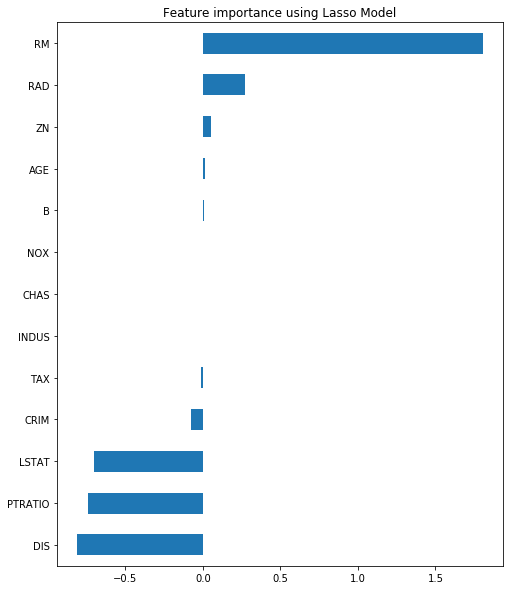

In [12]:
# load libraries
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

# build lasso object
reg = LassoCV()

# fit to data
reg.fit(X, y)

# expose score of fit
print("Best alpha using built-in LassoCV: %f" % reg.alpha_) # how many features will have their co-efficients set to 0
print("Best score using built-in LassoCV: %f" % reg.score(X,y)) # r2 value after feature extraction
coef = pd.Series(reg.coef_, index = X.columns) # extract new co-efficients (including 0s after lasso)

# count of features removed/set to 0
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

# sort new co-efficients
imp_coef = coef.sort_values()

# plot features and their lasso co-efficients
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

The histogram above shows that 10 of the features retained their co-efficients whilst 3 were set to 0 and thus removed from the features **(i.e. NOX, CHAS and INDUS)**

The key here is that linear regressions will calculate co-efficients for each feature in order to build the line/plane/hyper-plane regression of the data. Lasso identifies which features are the least significant (the number it chooses to identify depends on the alpha threshold - 0 is no effect, 1 is all features) and then sets these to 0 to essentially remove them from the regression. It's a dynamic way of performing feature extraction and can be very useful for huge datasets where you want to strictly remove x% of your features to leave you with a significant few.